Epoch 1/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 44s 113ms/step - accuracy: 0.6705 - loss: 0.9332 - val_accuracy: 0.8487 - val_loss: 0.4240
Epoch 2/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 42s 112ms/step - accuracy: 0.8480 - loss: 0.4252 - val_accuracy: 0.8687 - val_loss: 0.3625
Epoch 3/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 111ms/step - accuracy: 0.8709 - loss: 0.3587 - val_accuracy: 0.8834 - val_loss: 0.3196
Epoch 4/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 80s 106ms/step - accuracy: 0.8845 - loss: 0.3238 - val_accuracy: 0.8898 - val_loss: 0.2940
Epoch 5/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 106ms/step - accuracy: 0.8921 - loss: 0.2948 - val_accuracy: 0.8941 - val_loss: 0.2820
Epoch 6/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 42s 108ms/step - accuracy: 0.8992 - loss: 0.2780 - val_accuracy: 0.8993 - val_loss: 0.2769
Epoch 7/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 109ms/step - accuracy: 0.9060 - loss: 0.2566 - val_accuracy: 0.9012 - val_loss: 0.2628
Epoch 8/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 81s 108ms/step - accuracy: 0.9122 - loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
763/763 ━━━━━━━━━━━━━━━━━━━━ 44s 56ms/step - accuracy: 0.7176 - loss: 0.7920 - val_accuracy: 0.8610 - val_loss: 0.3775
Epoch 2/15
763/763 ━━━━━━━━━━━━━━━━━━━━ 83s 57ms/step - accuracy: 0.8621 - loss: 0.3770 - val_accuracy: 0.8823 - val_loss: 0.3136
Epoch 3/15
763/763 ━━━━━━━━━━━━━━━━━━━━ 81s 56ms/step - accuracy: 0.8816 - loss: 0.3243 - val_accuracy: 0.8942 - val_loss: 0.2893
Epoch 4/15
763/763 ━━━━━━━━━━━━━━━━━━━━ 45s 58ms/step - accuracy: 0.8942 - loss: 0.2841 - val_accuracy: 0.8974 - val_loss: 0.2754
Epoch 5/15
763/763 ━━━━━━━━━━━━━━━━━━━━ 83s 60ms/step - accuracy: 0.9038 - loss: 0.2569 - val_accuracy: 0.9021 - val_loss: 0.2586
Epoch 6/15
763/763 ━━━━━━━━━━━━━━━━━━━━ 45s 59ms/step - accuracy: 0.9101 - loss: 0.2436 - val_accuracy: 0.9077 - val_loss: 0.2477
Epoch 7/15
763/763 ━━━━━━━━━━━━━━━━━━━━ 80s 56ms/step - accuracy: 0.9135 - loss: 0.2307 - val_accuracy: 0.9101 - val_loss: 0.2447
Epoch 8/15
763/763 ━━━━━━━━━━━━━━━━━━━━ 82s 56ms/step - accuracy: 0.9214 - loss: 0.2125 - 

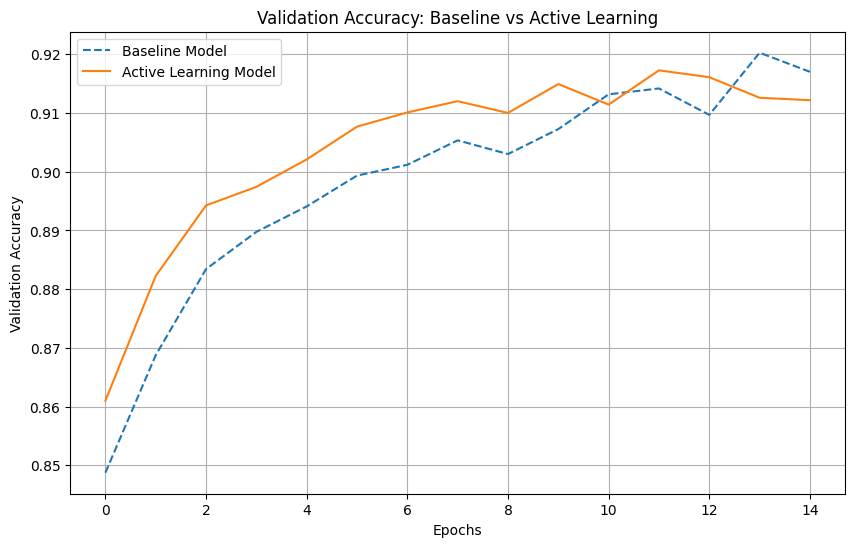

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from scipy.stats import entropy
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Load and preprocess the Fashion-MNIST dataset
(train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()

# Normalize data
train_images = train_images / 255.0
test_images = test_images / 255.0

# Split the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42
)

# Add a channel dimension for compatibility with CNN
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = test_images[..., np.newaxis]

# Define a CNN architecture
def build_cnn():
    cnn_model = keras.Sequential([
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(10, activation='softmax')
    ])
    cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return cnn_model

# Uncertainty metrics for active learning
def least_confidence(preds):
    return np.argsort(-np.max(preds, axis=1))

def entropy_based_selection(preds):
    return np.argsort(-entropy(preds.T))

def margin_based_sampling(preds):
    sorted_preds = -np.sort(-preds, axis=1)
    margins = sorted_preds[:, 0] - sorted_preds[:, 1]
    return np.argsort(margins)

# Diversity metric using cosine similarity
def diversity_via_cosine(features):
    sim_matrix = cosine_similarity(features)
    diversity_scores = 1 - sim_matrix.sum(axis=1)
    return np.argsort(-diversity_scores)

# Combine uncertainty and diversity metrics
def combined_score(preds, features, alpha=0.6):
    uncertainty = entropy_based_selection(preds)
    diversity = diversity_via_cosine(features)
    combined = alpha * uncertainty + (1 - alpha) * diversity
    return np.argsort(-combined)

# Active learning selection function
def active_learning(model, pool_data, n_select, metric_fn):
    preds = model.predict(pool_data)
    if metric_fn in [least_confidence, entropy_based_selection, margin_based_sampling]:
        selected = metric_fn(preds)[:n_select]
    else:
        features = model.predict(pool_data, batch_size=256)
        selected = metric_fn(preds, features)[:n_select]
    return selected

# Train the baseline model
baseline_model = build_cnn()
history_baseline = baseline_model.fit(
    X_train, y_train, epochs=15, batch_size=128, validation_data=(X_val, y_val)
)
baseline_val_accuracy = baseline_model.evaluate(X_val, y_val, verbose=0)[1]
print(f"Validation Accuracy (Baseline): {baseline_val_accuracy:.2f}")

# Active learning process
samples_to_select = 800
selected_indices = active_learning(baseline_model, X_val, samples_to_select, combined_score)
X_selected = X_val[selected_indices]
y_selected = y_val[selected_indices]

# Augment training data
X_augmented = np.concatenate((X_train, X_selected), axis=0)
y_augmented = np.concatenate((y_train, y_selected), axis=0)

# Train a new model with augmented data
model_with_al = build_cnn()
history_al = model_with_al.fit(
    X_augmented, y_augmented, epochs=15, batch_size=64, validation_data=(X_val, y_val)
)
al_val_accuracy = model_with_al.evaluate(X_val, y_val, verbose=0)[1]
print(f"Validation Accuracy (Active Learning): {al_val_accuracy:.2f}")

# Plot validation accuracy comparison
plt.figure(figsize=(10, 6))
plt.plot(history_baseline.history['val_accuracy'], label='Baseline Model', linestyle='--')
plt.plot(history_al.history['val_accuracy'], label='Active Learning Model')
plt.title('Validation Accuracy: Baseline vs Active Learning')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()
